##Preliminaries for the SCM part

Import useful libraries

In [ ]:
!pip install dowhy
!apt install libgraphviz-dev
!pip install pygraphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 10.2 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 45 not upgraded.
Need to get 2,433 kB of archives.
After this operation, 7,694 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2 

In [ ]:
import numpy as np
import random
from scipy import stats
import time
from collections import defaultdict
import warnings
from scipy.stats import rankdata
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import dowhy
from dowhy import CausalModel
import graphviz as gr
import pygraphviz

Useful functions for the SCM part

In [ ]:
def same(x):
    return x

def cube(x):
    return np.power(x, 3)

def negexp(x):
    return np.exp(-np.abs(x))

##Preliminaries for the estimation of effects parts

Install the shap library

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 5.7 MB/s eta 0:00:00


Import useful librairies

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
import shap

## **Exercise 1**

### **Intervention and counterfactual through an example**

We simulate an example
$$T=f_1(a_1\cdot X+\varepsilon_1)$$
$$Y=f_2(a_2\cdot T+ b_2\cdot X+\varepsilon_2)$$
where $X,\varepsilon_1,\varepsilon_2$ are independent random variables whose distribution is known

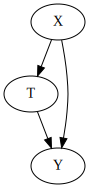

In [ ]:
g = gr.Digraph()
g.edge("X", "T"), g.edge("T", "Y"), g.edge("X", "Y")
g

**Q1-Generate the SCM**

In [ ]:
def same(x):
    return x

def carre(x):
    return np.power(x, 2)

def cube(x):
    return np.power(x, 3)

def negexp(x):
    return np.exp(-np.abs(x))

In [ ]:
def generate_samples(size,fixed_function1,fixed_function2, dist_x,dx,a1,a2,b2,nstd,seed = None,normalize=True):
    '''Generate independent post-nonlinear samples
    Arguments:
        size : number of samples
        f1, f2 to be within {x,x^2,x^3,tanh x, e^{-|x|}, cos x}
    Output:
        Samples X,T,Y
    '''
    if seed == None:
        np.random.seed()
    else:
        np.random.seed(seed)

    if fixed_function1 == 'linear':
      f1 = same
    elif fixed_function1=='carre':
      f1 = np.square
    elif fixed_function1=='cube':
      f1 = cube
    elif fixed_function1=='negexp':
      f1 = negexp
    else:
      f1 = np.cos

    if fixed_function2 == 'linear':
      f2= same
    elif fixed_function2=='carre':
      f2 = np.square
    elif fixed_function2=='cube':
      f2 = cube
    elif fixed_function2=='negexp':
      f2 = negexp
    else:
      f2 = np.cos

    if dist_x =='gaussian':
        cov = np.eye(dx)
        mu = np.ones(dx)
        X = np.random.multivariate_normal(mu, cov, size)

    elif dist_x == 'laplace':
        X = np.random.laplace(loc=0.0, scale=1.0, size=size*dx)
        if (dx!=1):
          X = np.reshape(X,(size,dx))

    T = f1(np.dot(a1,X)+nstd * np.random.normal(0, 1, size))
    Y = f2(np.dot(a2,T)+b2*X+nstd * np.random.normal(0, 1, size))

    if normalize == True:
        X = (X - X.min()) / (X.max() - X.min())
        T = (T - T.min()) / (T.max() - T.min())
        Y = (Y - Y.min()) / (Y.max() - Y.min())

    return [X,T,Y]

In [ ]:
[X,T,Y]=generate_samples(100,'cube','carre', 'gaussian',1,1.0,2.0,1.0,1.0,43)
df_mediator=pd.DataFrame({'X':X[:,0],'T':T[:,0],'Y':Y[:,0]})
df_mediator

,X,T,Y
0,0.534263,0.260569,0.000540
1,0.263968,0.249165,0.000028
2,0.386837,0.251142,0.000085
3,0.350574,0.250173,0.000057
4,0.673522,0.281381,0.002728
...,...,...,...
95,0.423019,0.252553,0.000132
96,0.497060,0.257181,0.000337
97,0.430913,0.252929,0.000145
98,0.843581,0.329592,0.013870


**Q2-Intervene on $T$ setting $T:=3$**

In [ ]:
def generate_samples_intervene(size,fixed_function1,fixed_function2, value_t,dist_x,dx,a1,a2,b2,nstd,seed = None,normalize=True):
    '''Generate independent post-nonlinear samples
    Arguments:
        size : number of samples
        f1, f2 to be within {x,x^2,x^3,tanh x, e^{-|x|}, cos x}
    Output:
        Samples T, M,Y
    '''
    print(seed)
    if seed == None:
        np.random.seed()
    else:
        np.random.seed(seed)

    if fixed_function1 == 'linear':
      f1 = same
    elif fixed_function1=='carre':
      f1 = np.square
    elif fixed_function1=='cube':
      f1 = cube
    elif fixed_function1=='negexp':
      f1 = negexp
    else:
      f1 = np.cos

    if fixed_function2 == 'linear':
      f2= same
    elif fixed_function2=='carre':
      f2 = np.square
    elif fixed_function2=='cube':
      f2 = cube
    elif fixed_function2=='negexp':
      f2 = negexp
    else:
      f2 = np.cos

    if dist_x =='gaussian':
        cov = np.eye(dx)
        mu = np.ones(dx)
        X = np.random.multivariate_normal(mu, cov, size)

    elif dist_x == 'laplace':
        X = np.random.laplace(loc=0.0, scale=1.0, size=size*dx)
        if (dx!=1):
          X = np.reshape(X,(size,dx))


    Y = f2(np.dot(a2,value_t)+b2*X+nstd * np.random.normal(0, 1, size))

    if normalize == True:
        X = (X - X.min()) / (X.max() - X.min())
        T =value_t*np.ones((len(X),1))
        Y = (Y - Y.min()) / (Y.max() - Y.min())

    return [X,T,Y]

In [ ]:
[X,T,Y]=generate_samples_intervene(100,'cube','carre', 3.0,'gaussian',1,1,2,1,1,43)
df_intervene=pd.DataFrame({'X':X[:,0],'T':T[:,0],'Y':Y[:,0]})
df_intervene

43


,X,T,Y
0,0.534263,3.0,0.377819
1,0.263968,3.0,0.261186
2,0.386837,3.0,0.311753
3,0.350574,3.0,0.296404
4,0.673522,3.0,0.445627
...,...,...,...
95,0.423019,3.0,0.327423
96,0.497060,3.0,0.360593
97,0.430913,3.0,0.330889
98,0.843581,3.0,0.535549


### **Counterfactuals**

We assume now that we have observed $(X,T,Y)=(1,-1,1)$ with $f_1=f_2:=t\mapsto t$, $a_1=a_2=b_2=1$.

**Q3-What are the value of the two noises $\varepsilon_1,\varepsilon_2$?**

The example becomes
$$-1=1+\varepsilon_1$$
$$1=-1+1+\varepsilon_2$$
Hence $\varepsilon_1=-2,\varepsilon_2=1$

**Q4-What would have happen if $T:=2$?**

Since $$Y=T+ X+\varepsilon_2$$ and $$T=2,X=1,\varepsilon_2=1$$ one has $Y=2+1+1=4$

## **Exercise 2**

###**Estimation of the effects on a complex example**

In [ ]:
def get_importances(predictors, outcome, feature_names, standardize=False):
    '''Gets bi-covs, bi-corrs,linear reg coeffs, RF importances, RF shap and MLP/NN shap output.
    :param predictors: array of preds (N, D)
    :param outcome: array of outcome (N, 1)
    :param feature_names: list of var names as strings
    :param standardize: where to standardize the data (does not apply to the computation of
    biv_covs, biv_corrs, or lr_coefs).
    :return as np.arrays (D,) of biv_corrs, biv_covs, rf_imps, rf_shaps, nn_shap, lin_coefs'''

    biv_covs = []
    biv_corrs = []
    for i in range(predictors.shape[1]):
        biv_covs.append(np.abs(np.cov(predictors[:, i], outcome,))[0,1])
        biv_corrs.append(np.abs(np.corrcoef(predictors[:, i], outcome,))[0,1])

    print('------------LR (always unstandardizd)---------------')
    # compare with linear regression coefficients
    reg = LinearRegression().fit(predictors, outcome)
    X_train, X_test, y_train, y_test = train_test_split(predictors, outcome, test_size=0.4, random_state=42)
    predictions = reg.predict(X_test)
    lr_coefs =  np.abs(reg.coef_)
    print('MSE', mean_squared_error(predictions, y_test))


    if standardize:
        predictors = ((predictors - predictors.mean(0)) / (predictors.std(0)))
        X_train, X_test, y_train, y_test = train_test_split(predictors, outcome, test_size=0.4, random_state=42)


    print('------------RF---------------')
    forest = RandomForestRegressor(random_state=0)
    forest.fit(X_train, y_train)
    predictions = forest.predict(X_test)
    rf_importances = forest.feature_importances_


    shap_sample_inds_train = np.random.choice(np.arange(0,len(X_train)), 500)
    shap_sample_inds_test = np.random.choice(np.arange(0,len(X_test)), 500)
    explainer = shap.TreeExplainer(forest, X_train[shap_sample_inds_train])
    rf_shap_vals = np.mean(np.abs(explainer.shap_values(X_test[shap_sample_inds_test], approximate=True)),0)
    print('MSE', mean_squared_error(predictions, y_test))

    print('------------NN---------------')
    nn_regr = MLPRegressor(hidden_layer_sizes=(100,),
                           activation='relu', solver='adam', alpha=0.0001,
                           batch_size='auto', learning_rate='adaptive',
                           learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True,)
    nn_regr.fit(X_train, y_train)
    predictions = nn_regr.predict(X_test)

    explainer = shap.KernelExplainer(nn_regr.predict, shap.sample(X_train, 500))
    nn_shap_vals = np.mean(np.abs(explainer.shap_values(X_test, nsamples=500)),0)
    print('MSE', mean_squared_error(predictions, y_test))



    return np.asarray(biv_covs), np.asarray(biv_corrs), rf_importances, rf_shap_vals, nn_shap_vals, lr_coefs

In [ ]:
def plot_results(biv_corrs, rf_importances, rf_shap_vals, nn_shap_vals, lr_coef, feature_names, graph_name):
    '''Bar plot with variables and different importance measures.'''

    all_results = pd.DataFrame([lr_coef, rf_importances, rf_shap_vals, nn_shap_vals]).T
    all_results.index = feature_names
    cols = ['LR-coefs', 'RF-imps', 'RF-Shap', 'NN-Shap']
    all_results.columns = cols
#     min_, max_ = all_results.min(), all_results.max()
#     m = (1 - min_) / (max_ - min_)
#     b = min_ - m*min_
#     all_results = all_results *m + b
    all_results.clip(lower=0, upper=1, inplace=True)
    all_results['bi-corrs'] = biv_corrs
    all_results['Var Names'] = all_results.index

    ax = plt.figure(figsize=(10, 6)).add_subplot(111)
    all_results.plot(ax=ax, x="Var Names", y=cols.append('bi-corrs'), kind="bar",fontsize=16, alpha=0.7)
    bars = ax.patches
    hatches = ''.join(h*len(all_results) for h in 'x/O.')
    for bar, hatch in zip(bars, hatches):
        bar.set_hatch(hatch)
    ax.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=5,fontsize=12)
    ax.set_ylim(0, 1.15)
    ax.figure.savefig(graph_name, dpi=200)

### **Example** 1

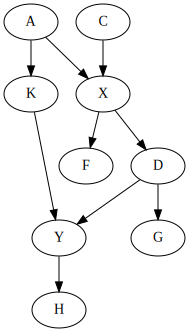

In [ ]:
g = gr.Digraph()
g.edge("A", "K"), g.edge("C", "X"), g.edge("A", "X"),g.edge("X","F"), g.edge("X","D"),g.edge("D","G"),g.edge("K","Y"),g.edge("D","Y"),g.edge("Y","H")
g

We associate a LinGAM to this graph

In [ ]:
N = 200

###############################################################
######## EITHER RUN: ########
low_corr = 0
C = np.random.randn(N,1)   # exogenous cause of X
A = 0.8 * np.random.randn(N,1)  # backdoor adjustment variable (also cause of X)
K = A + 0.1 * np.random.randn(N,1)  # backdoor adjustment variable (cause of A and Y)
X = C - 2*A + 0.2 * np.random.randn(N,1)  # treatment variable
F = 3*X + 0.8 * np.random.randn(N,1)  # descendent of treatment variable
D = -2*X + 0.5 * np.random.randn(N,1)  # mediator between x and y
G = D + 0.5 * np.random.randn(N,1)  # descendent of mediator
Y = 2*K - D + 0.2 * np.random.randn(N,1)  # outcome variable
H = 0.5*Y + 0.1 * np.random.randn(N,1)  # effect of Y

feature_names = ['C', 'A', 'K', 'X', 'F', 'D', 'G', 'H']

### Q1-Investigate $X\rightarrow Y$ using classical importance measures. Start by looking at the result with ALL variables

In [ ]:
predictors = np.concatenate((C, A, K, X, F, D, G, H),1)
outcome =  Y[:,0]
# biv_covs,biv_corrs, rf_importances, rf_shap_vals, nn_shap_vals, lr_coefs = get_importances(predictors, outcome, feature_names)
# plot_results(biv_corrs, rf_importances, rf_shap_vals, nn_shap_vals, lr_coefs, feature_names, graph_name='all_preds.png')

biv_covs_a,biv_corrs_a, rf_importances_a, rf_shap_vals_a, nn_shap_vals_a, lr_coefs_a = get_importances(predictors, outcome, feature_names, standardize=True)

for i, corr in enumerate(biv_corrs_a):
    print(feature_names[i], corr)

------------LR (always unstandardizd)---------------
MSE 0.019372538384588512
------------RF---------------
MSE 0.15710775778162964
------------NN---------------


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/80 [00:00<?, ?it/s]

MSE 0.14208025313400396
C 0.752252823381583
A 0.6273612178901715
K 0.6082761794103015
X 0.9280955258149368
F 0.9190434915902358
D 0.9403237949226523
G 0.9322405381465463
H 0.9976529222828242


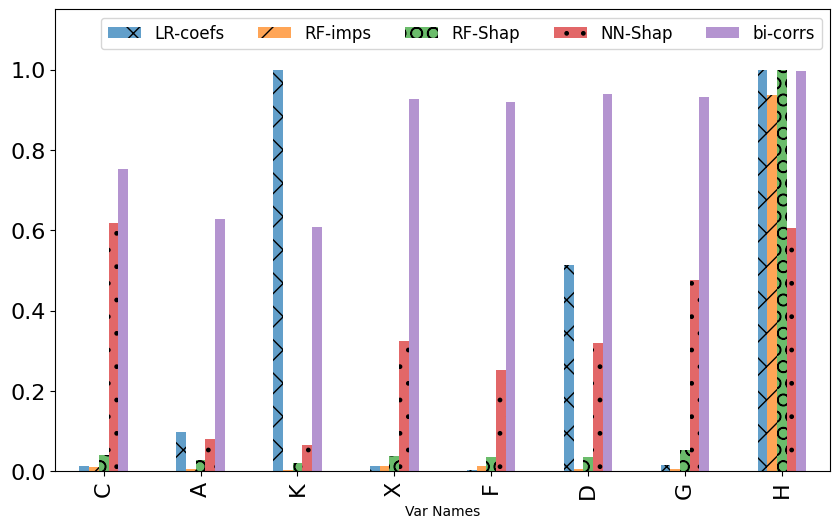

In [ ]:
gn = 'all_preds_std.png' if not low_corr else 'all_preds_std_low_corr.png'
plot_results(biv_corrs_a, rf_importances_a, rf_shap_vals_a, nn_shap_vals_a, lr_coefs_a, feature_names, graph_name=gn)

##Q2-Let's remove the effect of Y, which is 'H'


------------LR (always unstandardizd)---------------
MSE 0.03545160583011038
------------RF---------------


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MSE 0.4590319841965219
------------NN---------------


  0%|          | 0/80 [00:00<?, ?it/s]

MSE 0.1659835298169106


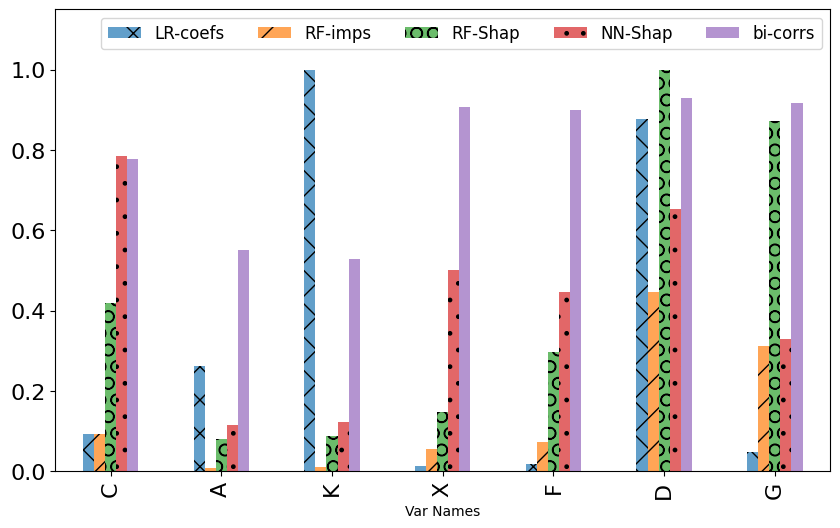

In [ ]:
# remove effect of y
predictors = np.concatenate((C, A, K, X, F, D, G),1)
outcome =  Y[:,0]
feature_names_b = ['C', 'A', 'K', 'X', 'F', 'D', 'G']

# biv_covs,biv_corrs, rf_importances, rf_shap_vals, nn_shap_vals, lr_coefs = get_importances(predictors, outcome, feature_names)
# plot_results(biv_corrs, rf_importances, rf_shap_vals, nn_shap_vals, lr_coefs, feature_names, graph_name='no_H.png')
gn = 'no_H_std.png' if not low_corr else 'no_H_std_low_corr.png'
biv_covs_b,biv_corrs_b, rf_importances_b, rf_shap_vals_b, nn_shap_vals_b, lr_coefs_b = get_importances(predictors, outcome, feature_names_b, standardize=True)
plot_results(biv_corrs_b, rf_importances_b, rf_shap_vals_b, nn_shap_vals_b, lr_coefs_b, feature_names_b, graph_name=gn)

##Q3-Now let's remove the mediator 'D'. Surely now we will see 'X' linked with 'Y'?

------------LR (always unstandardizd)---------------
MSE 0.1150080952109592
------------RF---------------
MSE 0.4973040230777099
------------NN---------------


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/80 [00:00<?, ?it/s]

MSE 0.19549599427237735


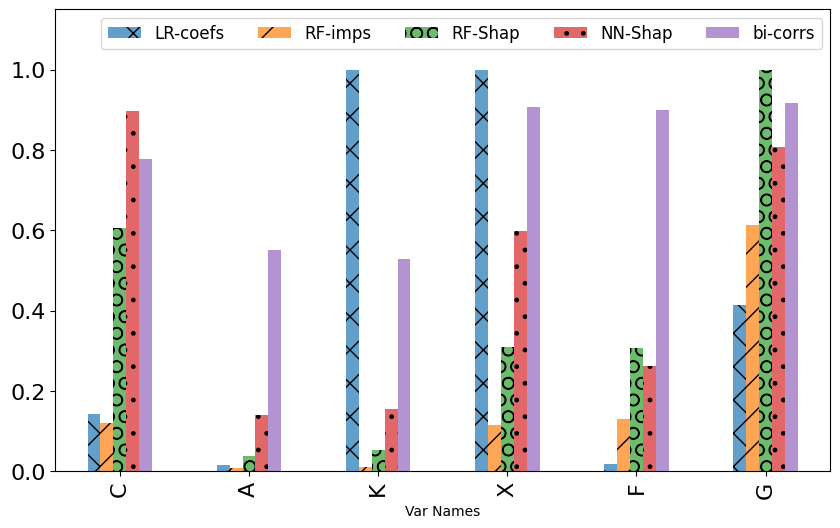

In [ ]:
# remove mediator
predictors = np.concatenate((C, A, K, X, F, G),1)
outcome =  Y[:,0]
feature_names_c = ['C', 'A', 'K', 'X', 'F', 'G']

# biv_covs,biv_corrs, rf_importances, rf_shap_vals, nn_shap_vals, lr_coefs = get_importances(predictors, outcome, feature_names)
# plot_results(biv_corrs, rf_importances, rf_shap_vals, nn_shap_vals, lr_coefs, feature_names, graph_name='no_H_no_D.png')

biv_covs_c,biv_corrs_c, rf_importances_c, rf_shap_vals_c, nn_shap_vals_c, lr_coefs_c = get_importances(predictors, outcome, feature_names_c, standardize=True)
gn = 'no_H_no_D_std.png' if not low_corr else 'no_H_no_D_std_low_corr.png'
plot_results(biv_corrs_c, rf_importances_c, rf_shap_vals_c, nn_shap_vals_c, lr_coefs_c, feature_names_c, graph_name=gn)

### **Example 2**

Q4-same with lower degrees of associations

In [ ]:
# #Alternatively, with lower levels of association
low_corr = 1
C = np.random.randn(N,1)   # exogenous cause of X
A = 0.8 * np.random.randn(N,1)  # backdoor adjustment variable (also cause of X)
K = 0.2*A + 0.1 * np.random.randn(N,1)  # backdoor adjustment variable (cause of A and Y)
X = 0.2*C - 0.4*A + 0.2 * np.random.randn(N,1)  # treatment variable
F = 0.6*X + 0.8 * np.random.randn(N,1)  # descendent of treatment variable
D = -0.4*X + 0.5 * np.random.randn(N,1)  # mediator between x and y
G = 0.2*D + 0.5 * np.random.randn(N,1)  # descendent of mediator
Y = 0.4*K - D + 0.2 * np.random.randn(N,1)  # outcome variable
H = 0.1*Y + 0.1 * np.random.randn(N,1)  # effect of Y
# ###############################################################
feature_names = ['C', 'A', 'K', 'X', 'F', 'D', 'G', 'H']

------------LR (always unstandardizd)---------------
MSE 0.03441554666944054
------------RF---------------
MSE 0.05140477232662401
------------NN---------------


  0%|          | 0/80 [00:00<?, ?it/s]

MSE 0.061620876305428916
C 0.08153204169290608
A 0.23142106436631468
K 0.1388828306305684
X 0.29141969874451457
F 0.11452673894089714
D 0.9236518301693287
G 0.2099133915079222
H 0.5234285077085562


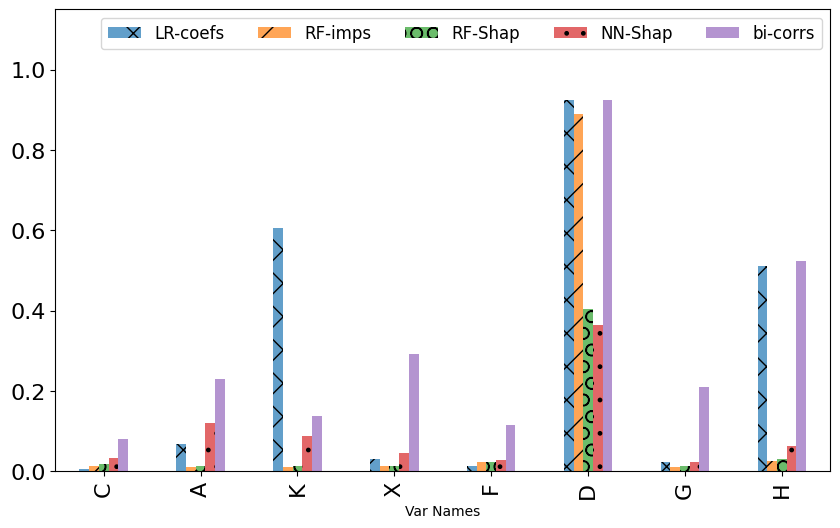

In [ ]:
predictors = np.concatenate((C, A, K, X, F, D, G, H),1)
outcome =  Y[:,0]
# biv_covs,biv_corrs, rf_importances, rf_shap_vals, nn_shap_vals, lr_coefs = get_importances(predictors, outcome, feature_names)
# plot_results(biv_corrs, rf_importances, rf_shap_vals, nn_shap_vals, lr_coefs, feature_names, graph_name='all_preds.png')

biv_covs_a,biv_corrs_a, rf_importances_a, rf_shap_vals_a, nn_shap_vals_a, lr_coefs_a = get_importances(predictors, outcome, feature_names, standardize=True)

for i, corr in enumerate(biv_corrs_a):
    print(feature_names[i], corr)
gn = 'all_preds_std.png' if not low_corr else 'all_preds_std_low_corr.png'
plot_results(biv_corrs_a, rf_importances_a, rf_shap_vals_a, nn_shap_vals_a, lr_coefs_a, feature_names, graph_name=gn)

------------LR (always unstandardizd)---------------
MSE 0.052454287117823316
------------RF---------------
MSE 0.06732485762275263
------------NN---------------


  0%|          | 0/80 [00:00<?, ?it/s]

MSE 0.06437929060784046


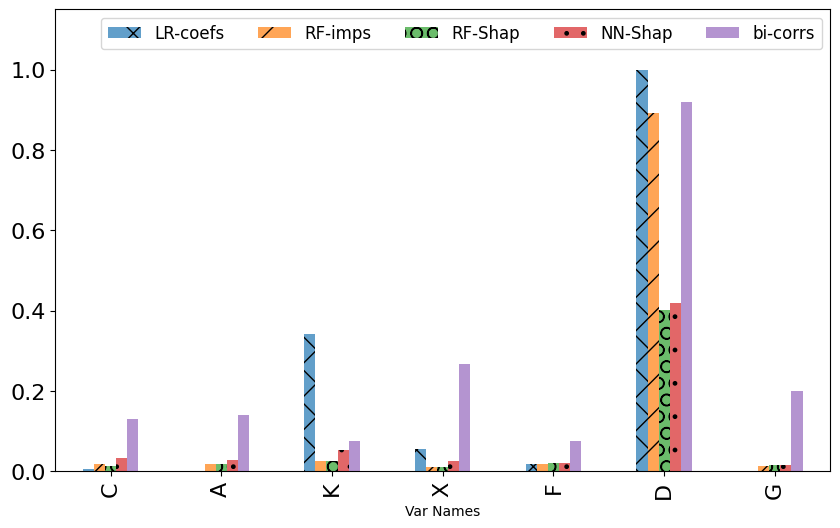

In [ ]:
# remove effect of y
predictors = np.concatenate((C, A, K, X, F, D, G),1)
outcome =  Y[:,0]
feature_names_b = ['C', 'A', 'K', 'X', 'F', 'D', 'G']

# biv_covs,biv_corrs, rf_importances, rf_shap_vals, nn_shap_vals, lr_coefs = get_importances(predictors, outcome, feature_names)
# plot_results(biv_corrs, rf_importances, rf_shap_vals, nn_shap_vals, lr_coefs, feature_names, graph_name='no_H.png')
gn = 'no_H_std.png' if not low_corr else 'no_H_std_low_corr.png'
biv_covs_b,biv_corrs_b, rf_importances_b, rf_shap_vals_b, nn_shap_vals_b, lr_coefs_b = get_importances(predictors, outcome, feature_names_b, standardize=True)
plot_results(biv_corrs_b, rf_importances_b, rf_shap_vals_b, nn_shap_vals_b, lr_coefs_b, feature_names_b, graph_name=gn)

------------LR (always unstandardizd)---------------
MSE 0.26020203016710663
------------RF---------------
MSE 0.29838738514374014
------------NN---------------


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  0%|          | 0/80 [00:00<?, ?it/s]

MSE 0.29864694863011093


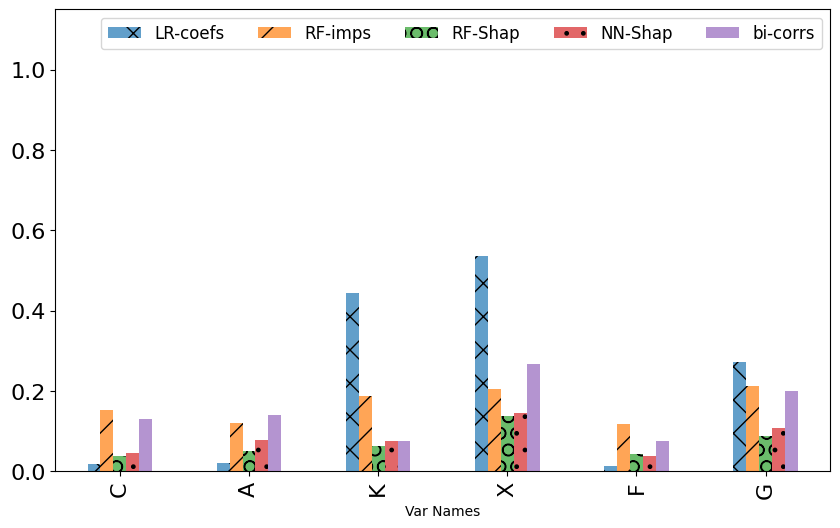

In [ ]:
# remove mediator
predictors = np.concatenate((C, A, K, X, F, G),1)
outcome =  Y[:,0]
feature_names_c = ['C', 'A', 'K', 'X', 'F', 'G']

# biv_covs,biv_corrs, rf_importances, rf_shap_vals, nn_shap_vals, lr_coefs = get_importances(predictors, outcome, feature_names)
# plot_results(biv_corrs, rf_importances, rf_shap_vals, nn_shap_vals, lr_coefs, feature_names, graph_name='no_H_no_D.png')

biv_covs_c,biv_corrs_c, rf_importances_c, rf_shap_vals_c, nn_shap_vals_c, lr_coefs_c = get_importances(predictors, outcome, feature_names_c, standardize=True)
gn = 'no_H_no_D_std.png' if not low_corr else 'no_H_no_D_std_low_corr.png'
plot_results(biv_corrs_c, rf_importances_c, rf_shap_vals_c, nn_shap_vals_c, lr_coefs_c, feature_names_c, graph_name=gn)

### **Estimation of the causal effect using the library dowhy**

In [ ]:
example1_array=np.concatenate((C, A, K, X, F, D, G, Y,H),axis=1)
df = pd.DataFrame(data = example1_array, columns=['C', 'A', 'K', 'X', 'F', 'D', 'G', 'Y','H'])

In [ ]:
causal_graph = """digraph {
F;
G;
H;
A->K;
A->X;
C->X;
X->F;
X->D;
K->Y;
D->Y;
D->G;
Y->H;
}"""

Q5-
Use the do why library to estimate $\mathbb{E}[Y|do(X=1)]-\mathbb{E}[Y|do(X=0)]$

In [ ]:
model=CausalModel(
        data = df,
        graph=causal_graph.replace("\n", " "),
        treatment="X",
        outcome="Y"
        )

In [ ]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

In [ ]:
causal_estimate_reg = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression",
        test_significance=True)
print(causal_estimate_reg)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d          
────(E[Y|A])
d[X]        
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,A,U) = P(Y|X,A)

## Realized estimand
b: Y~X+A+X*K
Target units: 

## Estimate
Mean value: 0.5079688529721194
p-value: [0.00057754]
### Conditional Estimates
__categorical__K
(-0.44, -0.143]     0.481307
(-0.143, -0.029]    0.498220
(-0.029, 0.0428]    0.507030
(0.0428, 0.167]     0.517383
(0.167, 0.485]      0.535904
dtype: float64
